>  <h1 style="color:#da8886"> Introduction </h1>


<p style="color:#cfc4c9;">In this notebook, we explore flower classification using deep learning techniques with the ResNet50 model. Our goal is to accurately classify different flower species by training the model on a dataset of flower images. We’ll cover data preparation, model training, and evaluation to showcase how deep learning can enhance image classification tasks.</p>


<div style="text-align: center;">
  <a href="https://ibb.co/mGHfsYz">
    <img src="https://i.ibb.co/CznRdX0/types-of-flowers-free-vector.jpg" alt="types-of-flowers-free-vector" style="max-width: 100%; height: auto;" border="0">
  </a>
</div>


# <h1 style="color:#da8886"> 01. Import Libraries</h1>


In [1]:
# Data Handling
import numpy as np
import pandas as pd
import glob

# Image Processing
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning and Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other
import os
import warnings
warnings.filterwarnings('ignore')
# Set the logging level to suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

2024-08-20 03:08:59.598455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 03:08:59.598558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 03:08:59.731772: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# <h1 style="color:#da8886"> 02. Load Data</h1>


In [2]:
image_data='/kaggle/input/flower-classification/train'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

Files_Name
0            astilbe
1   black_eyed_susan
2         bellflower
3      classname.txt
4       common_daisy
5          coreopsis
6          dandelion
7         water_lily
8          carnation
9          calendula
10  california_poppy
11         sunflower
12             tulip
13              rose
14              iris

In [3]:
# Collect all image file paths
files = glob.glob(os.path.join(image_data, '**', '*.*'), recursive=True)
np.random.shuffle(files)
labels = [os.path.basename(os.path.dirname(f)) for f in files]

# Create the DataFrame
data = {'Image': files, 'Label': labels}
dataframe = pd.DataFrame(data)
dataframe 

Image             Label
0      /kaggle/input/flower-classification/train/dand...         dandelion
1      /kaggle/input/flower-classification/train/iris...              iris
2      /kaggle/input/flower-classification/train/comm...      common_daisy
3      /kaggle/input/flower-classification/train/dand...         dandelion
4      /kaggle/input/flower-classification/train/wate...        water_lily
...                                                  ...               ...
13638  /kaggle/input/flower-classification/train/tuli...             tulip
13639  /kaggle/input/flower-classification/train/blac...  black_eyed_susan
13640  /kaggle/input/flower-classification/train/cale...         calendula
13641  /kaggle/input/flower-classification/train/tuli...             tulip
13642  /kaggle/input/flower-classification/train/iris...              iris

[13643 rows x 2 columns]

# <h1 style="color:#da8886"> 03. Viualization</h1>


In [4]:
colors_nude = ['#e0798c','#65365a','#da8886','#cfc4c4','#dfd7ca']

label_counts = dataframe['Label'].value_counts().reset_index()
label_counts.columns = ['Class_Name', 'Image_Count']
fig = px.bar(label_counts, 
             x='Class_Name', 
             y='Image_Count', 
             title='Number of Images per Flower Class', 
             text_auto=True, 
             color='Class_Name',
             color_discrete_sequence=colors_nude)  

fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(xaxis_title='Flower Class', yaxis_title='Number of Images', showlegend=False)

fig.show()


In [5]:
fig = px.pie(label_counts, 
             names='Class_Name', 
             values='Image_Count', 
             title='Proportion of Images per Flower Class', 
             color_discrete_sequence=colors_nude)

fig.update_traces(textfont_size=12, textposition="inside", pull=[0.1, 0, 0, 0, 0])

fig.show()

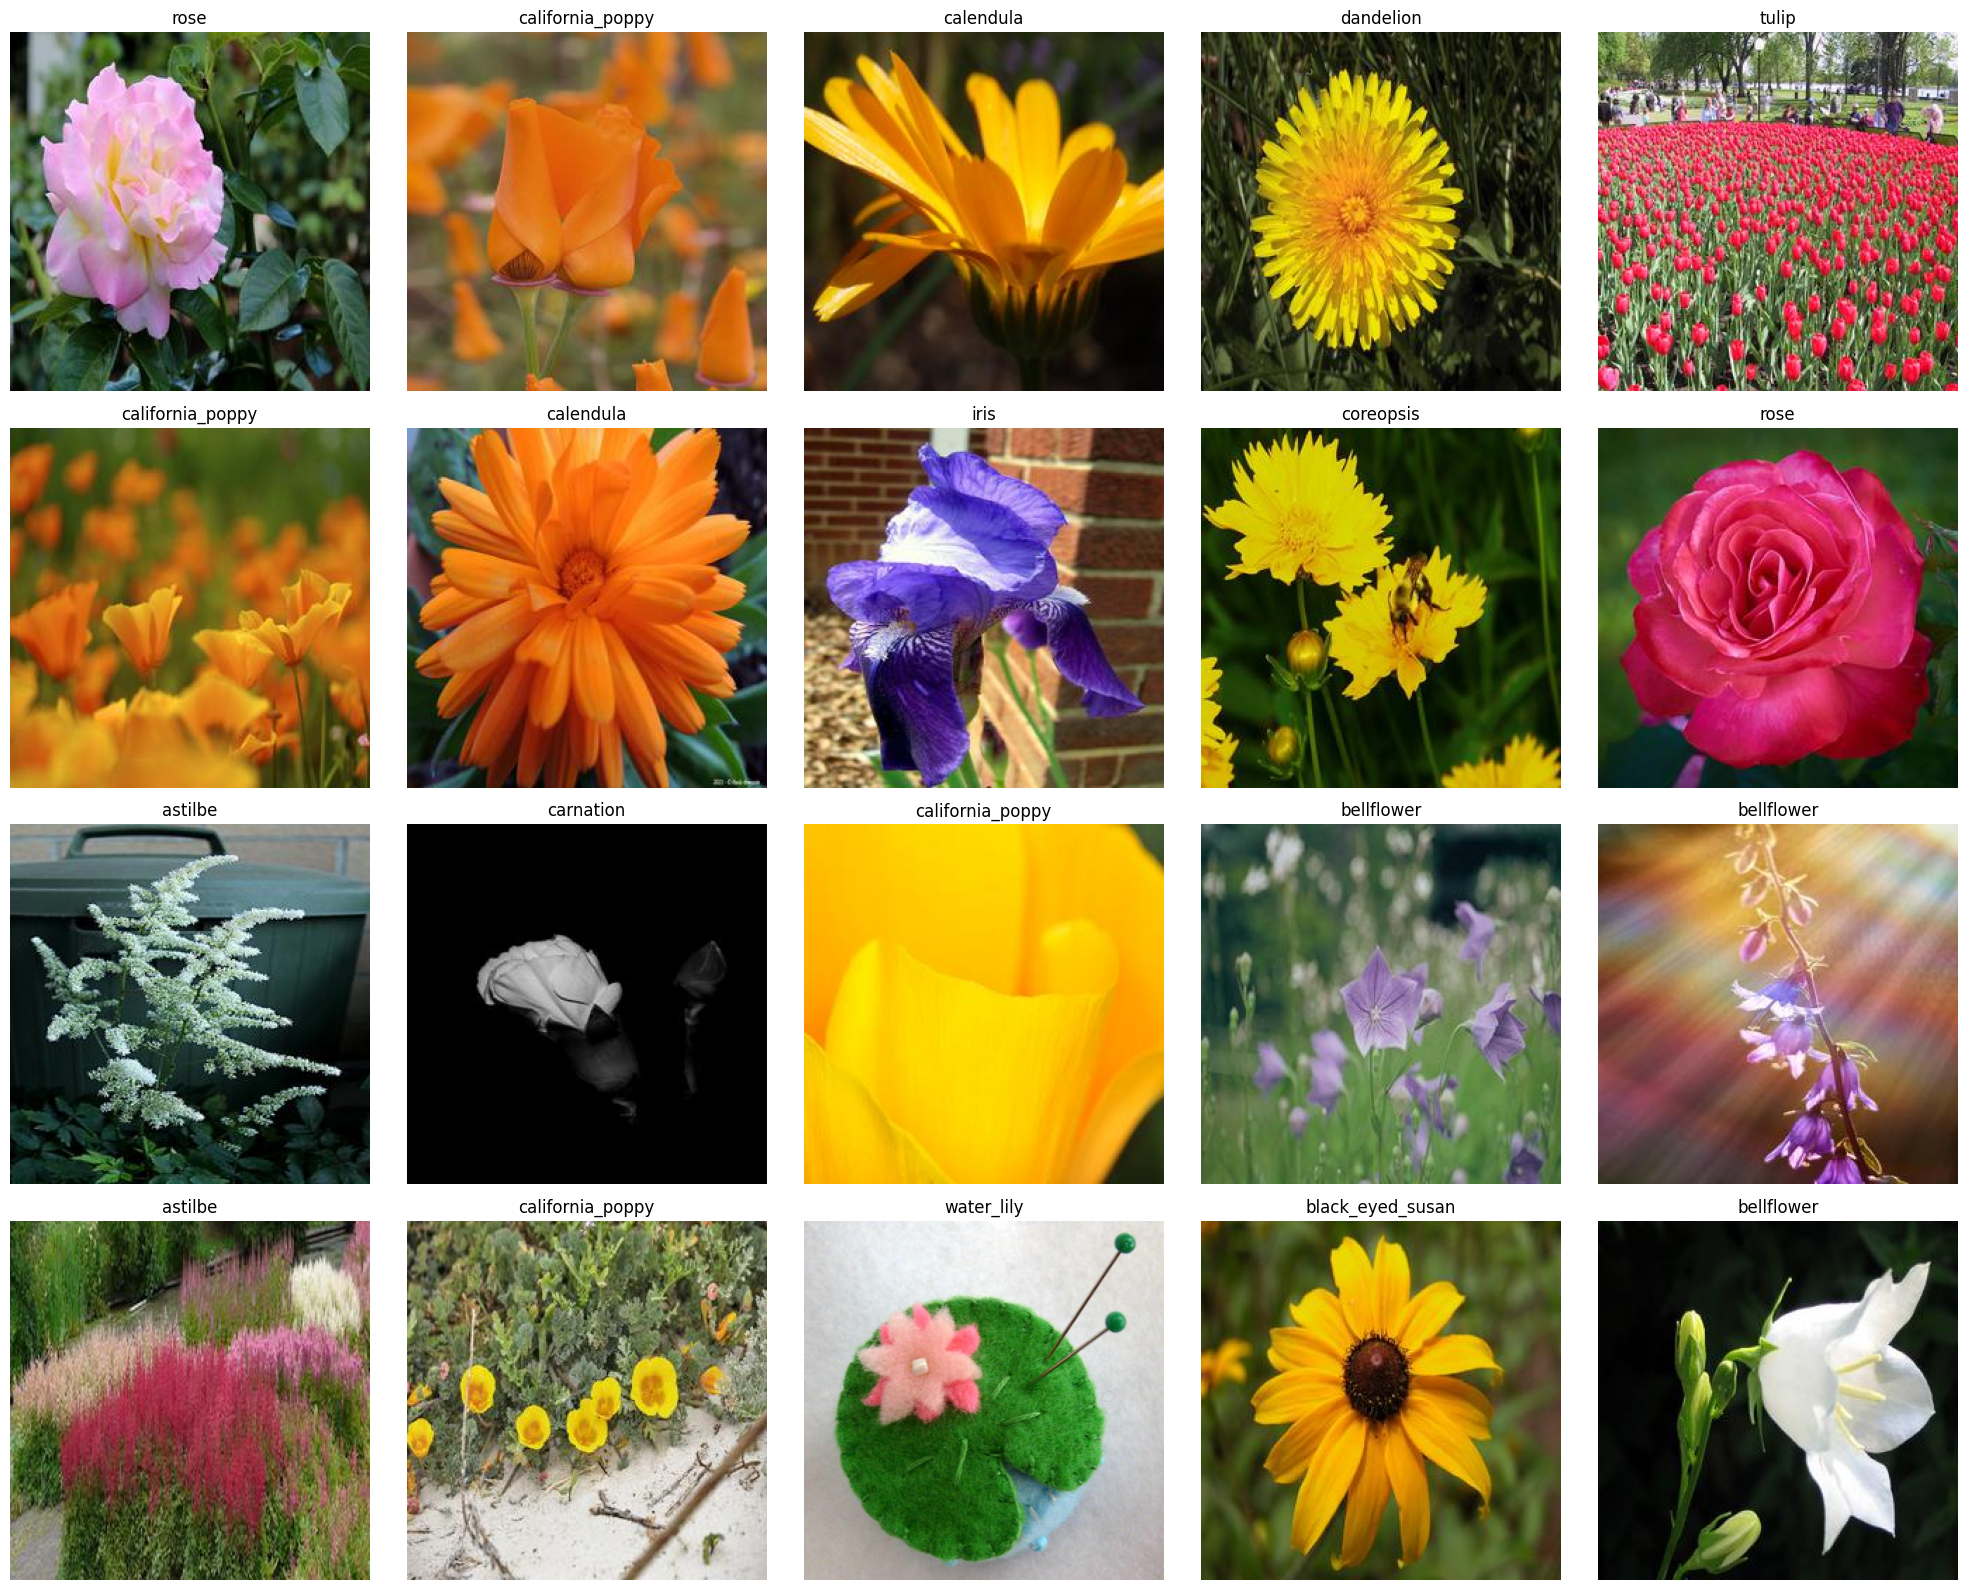

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def is_image_file(filename):
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}
    return os.path.splitext(filename)[1].lower() in image_extensions
dataframe = dataframe[dataframe['Image'].apply(is_image_file)]

sample_images = dataframe.sample(20).reset_index(drop=True)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))
for ax, (index, row) in zip(axes.flatten(), sample_images.iterrows()):
    img_path = row['Image']
    label = row['Label']
    
    try:
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(label)
    except Exception as e:
        ax.set_title("Error")
        print(f"Error loading image {img_path}: {e}")
    
    ax.axis('off')

plt.tight_layout()
plt.show()


# <h1 style="color:#da8886"> 04. Splitting Dataset</h1>


In [7]:
train_data_dir =image_data
batch_size = 32
target_size = (224,224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

Found 13642 files belonging to 14 classes.
Using 10914 files for training.
Found 13642 files belonging to 14 classes.
Using 2728 files for validation.



# <h1 style="color:#da8886"> 05. Building a Model</h1>


In [8]:
# Define the base model
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Create the sequential model
keras_model = keras.models.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(14, activation='softmax')
])

keras_model.build(input_shape=(None, 224, 224, 3))
keras_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │        28,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,616,398 (90.09 MB)

 Trainable params: 28,686 (112.05 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

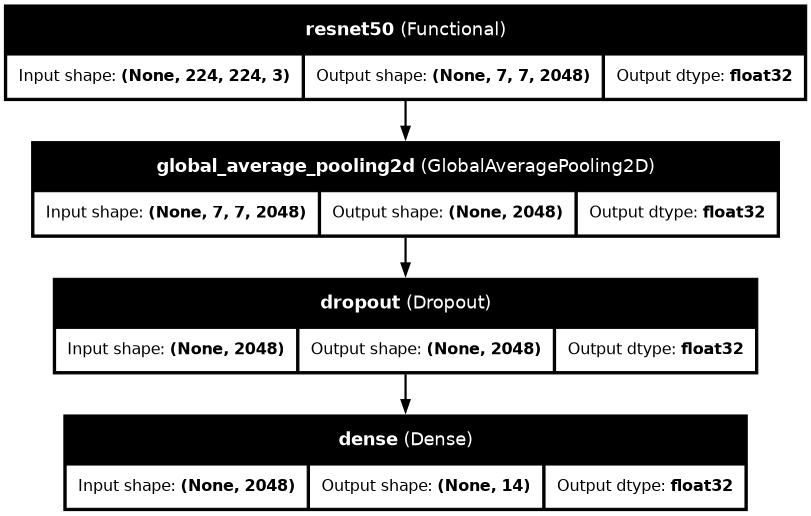

In [9]:
tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

# <h1 style="color:#da8886"> 06. Training the Model</h1>


In [10]:
# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("my_keras_model.keras", save_best_only=True)

In [11]:
early_stopping =EarlyStopping(patience=5, restore_best_weights=True)

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Compile the model
keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist = keras_model.fit(
    train, 
    epochs=40,
    validation_data=validation, 
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/40
  3/342 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.0590 - loss: 4.2631   

I0000 00:00:1724123384.045982      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724123384.101911      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5208 - loss: 1.6427

W0000 00:00:1724123407.366611      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


342/342 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.5213 - loss: 1.6409 - val_accuracy: 0.8724 - val_loss: 0.4013
Epoch 2/40
342/342 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.8311 - loss: 0.5185 - val_accuracy: 0.9040 - val_loss: 0.3011
Epoch 3/40
342/342 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.8688 - loss: 0.4124 - val_accuracy: 0.9271 - val_loss: 0.2481
Epoch 4/40
342/342 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.8727 - loss: 0.3759 - val_accuracy: 0.9362 - val_loss: 0.2157
Epoch 5/40
342/342 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.8915 - loss: 0.3371 - val_accuracy: 0.9359 - val_loss: 0.2048
Epoch 6/40
342/342 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.8931 - loss: 0.3215 - val_accuracy: 0.9399 - val_loss: 0.1849
Epoch 7/40
342/342 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.8986 - loss: 0.3054 - val_accuracy: 0.9465 - val_loss: 0.1729
Epoch 8/40
342/342 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.9019 - loss: 0.2921 - val_accurac


 # <h1 style="color:#da8886"> 07. Model Evaluation</h1>


In [13]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy      loss  val_accuracy  val_loss
0   0.685908  1.016922      0.872434  0.401327
1   0.845153  0.481478      0.903959  0.301109
2   0.871266  0.401735      0.927053  0.248059
3   0.877772  0.366214      0.936217  0.215668
4   0.888675  0.334316      0.935850  0.204755
5   0.898204  0.310432      0.939883  0.184908
6   0.899762  0.305750      0.946481  0.172922
7   0.903152  0.288767      0.949047  0.174427
8   0.902877  0.278186      0.946114  0.172447
9   0.905992  0.288263      0.955279  0.154793
10  0.912681  0.266819      0.950513  0.168283
11  0.915063  0.253916      0.958211  0.143362
12  0.910115  0.264011      0.953446  0.155024
13  0.912131  0.268041      0.958578  0.140311
14  0.911398  0.271786      0.959311  0.135946
15  0.917537  0.244731      0.956378  0.141445
16  0.919461  0.237192      0.957845  0.137476
17  0.917904  0.237769      0.955645  0.142058
18  0.916712  0.244933      0.959677  0.133208
19  0.919278  0.246389      0.957845  0.134579
20  0.915613  0.241324      0.960777  0.128142
21  0.921569  0.232485      0.962977  0.127874
22  0.921019  0.237407      0.960411  0.132390
23  0.918637  0.239828      0.965542  0.119367
24  0.923768  0.232623      0.962610  0.129762
25  0.926242  0.225726      0.966642  0.124398
26  0.919919  0.237573      0.965542  0.120219
27  0.923126  0.228403      0.960777  0.131623
28  0.926058  0.225547      0.964076  0.119389

In [14]:
score, acc = keras_model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9667 - loss: 0.1179
Test Loss = 0.11938945204019547
Test Accuracy = 0.9640762209892273


7.1. Training and Validation Loss

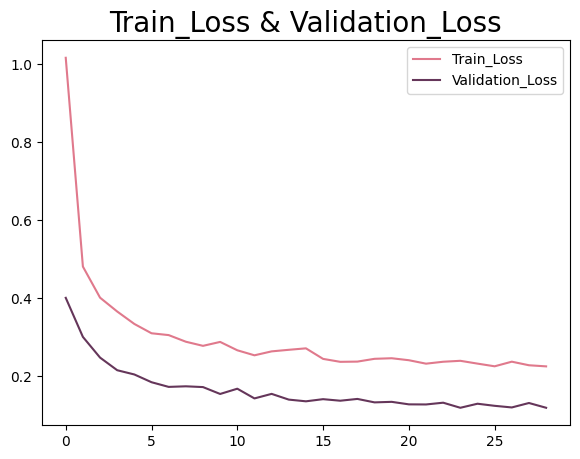

In [15]:
colors_nude = ['#e0798c', '#65365a', '#da8886', '#cfc4c4', '#dfd7ca']
plt.figure(figsize=(15,5))

# Plot Train Loss & Validation Loss
plt.subplot(1,2,1)
plt.plot(hist_['loss'], label='Train_Loss', color=colors_nude[0])
plt.plot(hist_['val_loss'], label='Validation_Loss', color=colors_nude[1]) 
plt.title('Train_Loss & Validation_Loss', fontsize=20)
plt.legend()


7.2. Training and Validation Accuracy

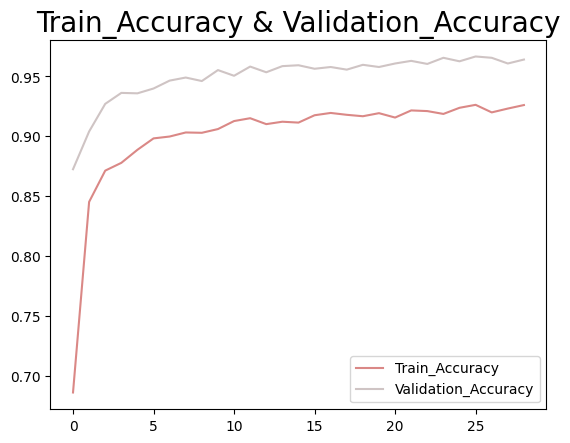

In [16]:
# Plot Train Accuracy & Validation Accuracy
plt.plot(hist_['accuracy'], label='Train_Accuracy', color=colors_nude[2]) 
plt.plot(hist_['val_accuracy'], label='Validation_Accuracy', color=colors_nude[3]) 
plt.title('Train_Accuracy & Validation_Accuracy', fontsize=20)
plt.legend()

7.3. Confusion Matrix

W0000 00:00:1724123949.806220      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


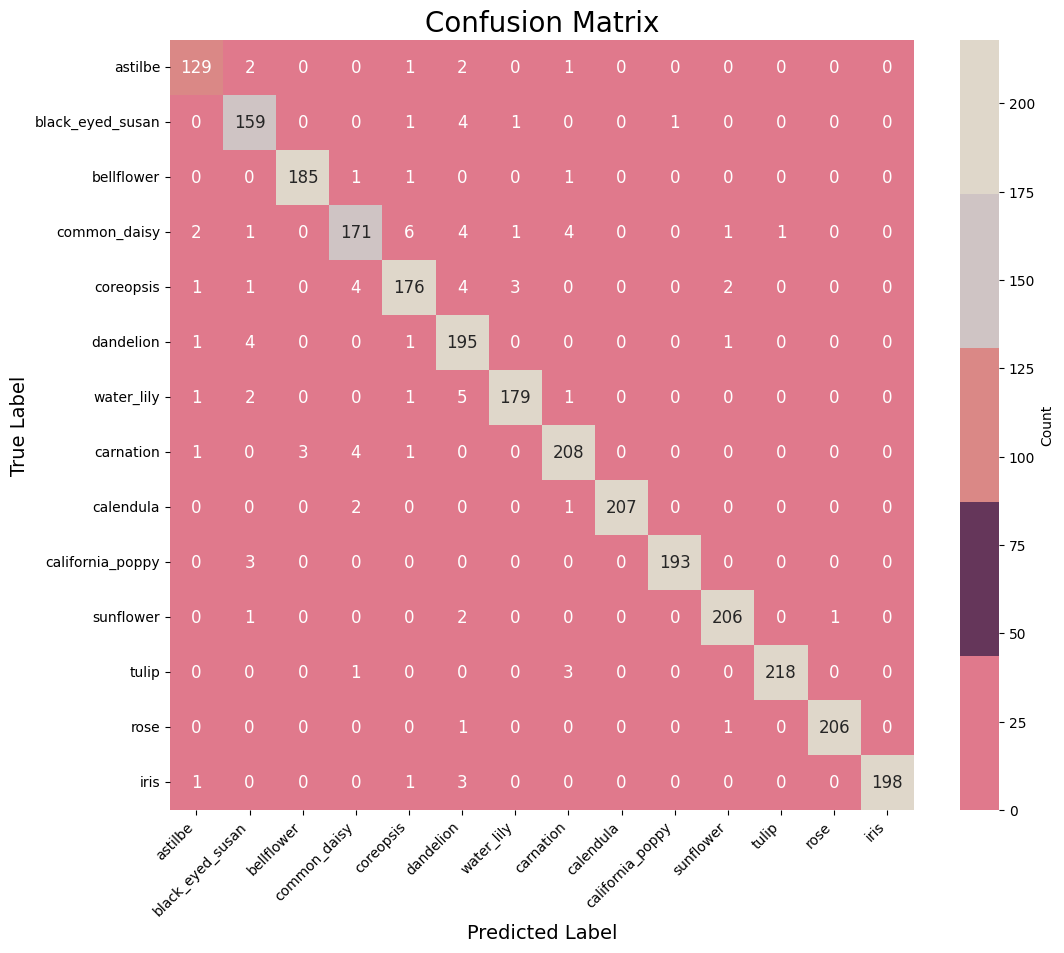

In [17]:
# Suppress TensorFlow logging
tf.get_logger().setLevel('ERROR')
cmap = sns.color_palette(colors_nude, as_cmap=True)

class_names = [
    'astilbe', 'black_eyed_susan', 'bellflower', 'common_daisy', 'coreopsis',
    'dandelion', 'water_lily', 'carnation', 'calendula', 'california_poppy',
    'sunflower', 'tulip', 'rose', 'iris'
]

# Extract true labels and predictions
y_true = []
y_pred = []

for x_batch, y_batch in validation:
    y_true.extend(y_batch.numpy()) 
    y_pred.extend(keras_model.predict(x_batch, verbose=0)) 

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=True, 
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 12}, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()